# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_176  I3L0N3;P46459                       15.500
Sample_043  M0R009                              22.950
Sample_015  P62736                              16.459
Sample_122  P12107;P12107-2;P12107-3;P12107-4   14.120
Sample_157  P25189;P25189-2                     14.559
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_107  A0A087WWA5       13.222
Sample_152  H0Y4H1           14.817
Sample_109  O75083           15.137
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.461
            A0A075B6Q5                 11.866
            A0A075B6R2                 13.726
            A0A075B6S5                 12.638
            A0A087WSY4                 14.619
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.061
            Q9UI40;Q9UI40-2            12.350
            Q9UIW2                     13.053
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.652
            Q9UP79                     13.872
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.166,15.050,16.842,19.863,15.929,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.598,19.067,...,15.528,15.576,14.034,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.867,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.273,17.705,17.039,15.990,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.441,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.476,15.345,17.084,18.708,14.249,19.433,11.571,11.358
Sample_207,15.739,16.877,15.469,16.898,15.321,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.899,12.998,12.902,11.781,13.891,12.604,12.949,13.327,14.278,13.081
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.857,19.067,16.127,...,12.897,12.755,12.571,12.698,13.099,11.672,13.270,13.986,12.433,12.440
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.216,11.270,12.842,12.529,12.482,11.797,11.854,12.741,13.362,12.577
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.274,14.325,12.405,13.166,12.819,12.994,12.082,13.332,12.176,11.954
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.970,12.327,12.822,12.926,14.050,12.607,14.236,14.922,12.333,13.389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.572,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 165.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.26it/s]

100%|██████████| 3/3 [00:00<00:00,  2.96it/s]

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.17it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.35it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.87it/s]

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.23it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.86it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.20it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.84it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.04it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.91it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.04it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.17it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.38it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.99it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.76it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.84it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.81it/s]

100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

100%|██████████| 8/8 [00:02<00:00,  3.91it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.91it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.80it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.31it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.10it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.56it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.75it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.95it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  4.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.75it/s]

 30%|███       | 3/10 [00:00<00:01,  5.11it/s]

 40%|████      | 4/10 [00:00<00:01,  4.66it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.37it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.25it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.67it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.61it/s]

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.74it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.57it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.90it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.63it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.53it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.20it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.23it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.24it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.53it/s]

100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.15it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.55it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.13it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.60it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.56it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.72it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.51it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.62it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.56it/s]

100%|██████████| 12/12 [00:03<00:00,  3.70it/s]

100%|██████████| 12/12 [00:03<00:00,  3.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.52it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.62it/s]

 31%|███       | 4/13 [00:00<00:02,  4.06it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.88it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.60it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.52it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.00it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.90it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.96it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.32it/s]

100%|██████████| 13/13 [00:03<00:00,  3.54it/s]

100%|██████████| 13/13 [00:03<00:00,  3.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.44it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.91it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.10it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.91it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.31it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.32it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.12it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.16it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.39it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.63it/s]

100%|██████████| 14/14 [00:03<00:00,  3.83it/s]

100%|██████████| 14/14 [00:03<00:00,  3.74it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.96it/s]

 20%|██        | 3/15 [00:00<00:02,  5.71it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.85it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.68it/s]

 40%|████      | 6/15 [00:01<00:01,  4.59it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.57it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.50it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.45it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.95it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.67it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.75it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.36it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  2.95it/s]

100%|██████████| 15/15 [00:03<00:00,  2.80it/s]

100%|██████████| 15/15 [00:03<00:00,  3.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.017          0.806 0.313       0.135   
2             0.004 0.002      0.045 0.017          0.606 0.130       0.472   
3             0.006 0.003      0.064 0.026          0.805 0.082       0.749   
4             0.004 0.002      0.047 0.015          0.794 0.083       0.775   
5             0.006 0.003      0.063 0.028          0.818 0.080       0.831   
6             0.006 0.003      0.067 0.024          0.823 0.081       0.823   
7             0.006 0.003      0.055 0.023          0.828 0.077       0.846   
8             0.005 0.003      0.056 0.024          0.832 0.077       0.846   
9             0.005 0.002      0.046 0.016          0.836 0.079       0.855   
10            0.005 0.002      0.046 0.018          0.815 0.071       0.847   
11            0.005 0.002      0.047 0.021          0.812 0.071       0.838   
12            0.004 0.002      0.042 0.019          0.820 0.076       0.839   
13            0.005 0.002      0.048 0.020          0.837 0.084       0.815   
14            0.004 0.001      0.038 0.007          0.837 0.080       0.809   
15            0.005 0.001      0.047 0.016          0.836 0.080       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.223 0.128                  0.560 0.041        0.850   
2          0.116   0.521 0.100                  0.619 0.069        0.698   
3          0.089   0.772 0.069                  0.807 0.056        0.916   
4          0.109   0.780 0.078                  0.813 0.065        0.920   
5          0.094   0.821 0.066                  0.846 0.057        0.921   
6          0.104   0.819 0.073                  0.845 0.062        0.921   
7          0.090   0.833 0.063                  0.857 0.055        0.922   
8          0.087   0.835 0.059                  0.858 0.052        0.921   
9          0.085   0.841 0.057                  0.863 0.051        0.921   
10         0.099   0.827 0.068                  0.853 0.059        0.923   
11         0.100   0.821 0.068                  0.847 0.058        0.920   
12         0.095   0.826 0.066                  0.851 0.057        0.918   
13         0.088   0.822 0.066                  0.848 0.056        0.924   
14         0.092   0.819 0.066                  0.846 0.055        0.921   
15         0.093   0.820 0.067                  0.846 0.056        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.823 0.089        210.000 0.000  
2          0.083                  0.650 0.099        210.000 0.000  
3          0.042                  0.905 0.042        210.000 0.000  
4          0.042                  0.903 0.046        210.000 0.000  
5          0.044                  0.909 0.045        210.000 0.000  
6          0.044                  0.910 0.045        210.000 0.000  
7          0.045                  0.914 0.044        210.000 0.000  
8          0.046                  0.913 0.043        210.000 0.000  
9          0.045                  0.913 0.042        210.000 0.000  
10         0.047                  0.915 0.044        210.000 0.000  
11         0.048                  0.910 0.047        210.000 0.000  
12         0.049                  0.908 0.049        210.000 0.000  
13         0.048                  0.915 0.047        210.000 0.000  
14         0.047                  0.912 0.048        210.000 0.000  
15         0.048                  0.909 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 505.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.86it/s]

100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.42it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.56it/s]

100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.69it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.48it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.01it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.06it/s]

100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.46it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.54it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.37it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.20it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.74it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.20it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.84it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.78it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.94it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.87it/s]

100%|██████████| 8/8 [00:01<00:00,  3.94it/s]

100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.61it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.23it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.56it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.49it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.28it/s]

100%|██████████| 9/9 [00:03<00:00,  2.21it/s]

100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.53it/s]

 30%|███       | 3/10 [00:00<00:01,  3.97it/s]

 40%|████      | 4/10 [00:01<00:01,  3.13it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.75it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.44it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.34it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.40it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.55it/s]

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.09it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.30it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.76it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.41it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.33it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.12it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.95it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.08it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.15it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.41it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.72it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.99it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.85it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.54it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.35it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.55it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.60it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.69it/s]

100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.84it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

 31%|███       | 4/13 [00:01<00:02,  3.06it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.08it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.08it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.99it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.97it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.94it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.05it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.13it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.17it/s]

100%|██████████| 13/13 [00:04<00:00,  3.07it/s]

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.23it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.04it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.73it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.52it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.92it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.77it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.37it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.27it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.20it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.32it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:05<00:00,  2.56it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.57it/s]

 20%|██        | 3/15 [00:00<00:03,  3.14it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.66it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.01it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.06it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.95it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.12it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.12it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.99it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.13it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.016          0.000 0.000       0.000   
2             0.004 0.002      0.050 0.019          0.672 0.116       0.443   
3             0.006 0.003      0.063 0.027          0.744 0.099       0.583   
4             0.005 0.003      0.058 0.023          0.730 0.086       0.574   
5             0.004 0.002      0.045 0.013          0.719 0.093       0.615   
6             0.004 0.002      0.045 0.020          0.777 0.098       0.746   
7             0.005 0.002      0.050 0.022          0.785 0.110       0.713   
8             0.004 0.001      0.038 0.011          0.777 0.100       0.721   
9             0.005 0.002      0.053 0.020          0.796 0.094       0.748   
10            0.004 0.001      0.042 0.013          0.771 0.093       0.772   
11            0.006 0.003      0.052 0.021          0.792 0.093       0.764   
12            0.004 0.000      0.039 0.008          0.819 0.092       0.806   
13            0.005 0.003      0.049 0.018          0.840 0.089       0.822   
14            0.005 0.002      0.047 0.016          0.840 0.088       0.824   
15            0.004 0.002      0.043 0.017          0.829 0.086       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.855   
2          0.123   0.524 0.106                  0.641 0.060        0.691   
3          0.127   0.644 0.090                  0.715 0.057        0.755   
4          0.124   0.634 0.087                  0.708 0.053        0.750   
5          0.110   0.657 0.082                  0.718 0.060        0.785   
6          0.109   0.755 0.077                  0.791 0.061        0.865   
7          0.118   0.739 0.086                  0.781 0.068        0.863   
8          0.129   0.740 0.089                  0.782 0.068        0.864   
9          0.108   0.766 0.077                  0.802 0.063        0.871   
10         0.116   0.765 0.080                  0.800 0.067        0.900   
11         0.119   0.771 0.080                  0.806 0.066        0.905   
12         0.117   0.806 0.077                  0.835 0.063        0.919   
13         0.107   0.826 0.077                  0.852 0.064        0.922   
14         0.101   0.828 0.074                  0.853 0.063        0.922   
15         0.111   0.813 0.079                  0.841 0.065        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.085                  0.660 0.086        210.000 0.000  
3          0.078                  0.697 0.097        210.000 0.000  
4          0.072                  0.683 0.089        210.000 0.000  
5          0.070                  0.741 0.093        210.000 0.000  
6          0.057                  0.847 0.063        210.000 0.000  
7          0.057                  0.842 0.068        210.000 0.000  
8          0.057                  0.840 0.071        210.000 0.000  
9          0.061                  0.845 0.075        210.000 0.000  
10         0.051                  0.872 0.063        210.000 0.000  
11         0.050                  0.879 0.061        210.000 0.000  
12         0.045                  0.899 0.054        210.000 0.000  
13         0.045                  0.903 0.054        210.000 0.000  
14         0.045                  0.903 0.054        210.000 0.000  
15         0.045                  0.902 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1008.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.89it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.69it/s]

100%|██████████| 3/3 [00:00<00:00, 15.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.87it/s]

100%|██████████| 4/4 [00:00<00:00, 19.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.05it/s]

100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

100%|██████████| 5/5 [00:00<00:00, 13.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.25it/s]

100%|██████████| 6/6 [00:00<00:00, 14.15it/s]

100%|██████████| 6/6 [00:00<00:00, 14.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.75it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.08it/s]

100%|██████████| 7/7 [00:00<00:00, 11.99it/s]

100%|██████████| 7/7 [00:00<00:00, 12.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.40it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.64it/s]

100%|██████████| 8/8 [00:00<00:00, 13.44it/s]

100%|██████████| 8/8 [00:00<00:00, 14.41it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.40it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.25it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.40it/s]

100%|██████████| 9/9 [00:00<00:00, 11.92it/s]

100%|██████████| 9/9 [00:00<00:00, 12.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.61it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.91it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.86it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.98it/s]

100%|██████████| 10/10 [00:00<00:00, 14.43it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.99it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.89it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.17it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.77it/s]

100%|██████████| 11/11 [00:00<00:00, 11.93it/s]

100%|██████████| 11/11 [00:00<00:00, 12.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.19it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.82it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.88it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.47it/s]

100%|██████████| 12/12 [00:00<00:00, 13.54it/s]

100%|██████████| 12/12 [00:00<00:00, 14.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.90it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.07it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.48it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.02it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.38it/s]

100%|██████████| 13/13 [00:01<00:00, 10.89it/s]

100%|██████████| 13/13 [00:01<00:00, 11.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.90it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.06it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.89it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.46it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.99it/s]

100%|██████████| 14/14 [00:01<00:00, 11.92it/s]

100%|██████████| 14/14 [00:01<00:00, 12.78it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.74it/s]

 33%|███▎      | 5/15 [00:00<00:00, 17.75it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.82it/s]

 60%|██████    | 9/15 [00:00<00:00, 15.60it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.89it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 14.97it/s]

100%|██████████| 15/15 [00:01<00:00, 13.91it/s]

100%|██████████| 15/15 [00:01<00:00, 14.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.042 0.013          0.000 0.000       0.000   
2             0.004 0.002      0.049 0.018          0.630 0.102       0.489   
3             0.004 0.002      0.046 0.016          0.625 0.104       0.547   
4             0.004 0.002      0.041 0.013          0.637 0.103       0.559   
5             0.004 0.002      0.046 0.015          0.672 0.097       0.560   
6             0.004 0.001      0.038 0.010          0.666 0.086       0.561   
7             0.005 0.002      0.050 0.018          0.658 0.097       0.588   
8             0.004 0.002      0.041 0.012          0.668 0.100       0.587   
9             0.005 0.002      0.047 0.015          0.666 0.100       0.590   
10            0.004 0.001      0.040 0.008          0.662 0.101       0.587   
11            0.005 0.003      0.045 0.017          0.648 0.114       0.575   
12            0.004 0.002      0.040 0.009          0.651 0.108       0.579   
13            0.004 0.003      0.042 0.017          0.659 0.105       0.588   
14            0.005 0.002      0.051 0.017          0.659 0.103       0.592   
15            0.006 0.003      0.062 0.026          0.655 0.112       0.582   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.750   
2          0.104   0.542 0.084                  0.636 0.056        0.696   
3          0.095   0.578 0.079                  0.650 0.064        0.752   
4          0.097   0.589 0.077                  0.660 0.059        0.755   
5          0.111   0.604 0.086                  0.678 0.062        0.779   
6          0.103   0.601 0.070                  0.674 0.048        0.779   
7          0.100   0.614 0.073                  0.679 0.057        0.779   
8          0.103   0.617 0.076                  0.682 0.060        0.778   
9          0.106   0.618 0.077                  0.683 0.059        0.774   
10         0.114   0.614 0.083                  0.680 0.062        0.767   
11         0.111   0.601 0.087                  0.668 0.069        0.761   
12         0.118   0.605 0.092                  0.673 0.069        0.764   
13         0.108   0.614 0.081                  0.678 0.065        0.764   
14         0.108   0.616 0.080                  0.680 0.064        0.760   
15         0.103   0.609 0.081                  0.673 0.068        0.768   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.692 0.085        210.000 0.000  
2          0.066                  0.665 0.069        210.000 0.000  
3          0.066                  0.688 0.083        210.000 0.000  
4          0.063                  0.703 0.080        210.000 0.000  
5          0.065                  0.731 0.083        210.000 0.000  
6          0.062                  0.733 0.078        210.000 0.000  
7          0.062                  0.734 0.079        210.000 0.000  
8          0.062                  0.729 0.078        210.000 0.000  
9          0.061                  0.725 0.078        210.000 0.000  
10         0.065                  0.718 0.082        210.000 0.000  
11         0.068                  0.714 0.084        210.000 0.000  
12         0.067                  0.716 0.082        210.000 0.000  
13         0.068                  0.717 0.079        210.000 0.000  
14         0.068                  0.714 0.080        210.000 0.000  
15         0.066                  0.720 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,3,15
score_time,6,3,15
test_precision,14,13,5
test_recall,9,14,14
test_f1,9,14,9
test_balanced_accuracy,9,14,9
test_roc_auc,13,13,5
test_average_precision,13,13,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.16it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.75it/s]

 31%|███       | 4/13 [00:01<00:03,  2.61it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.81it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.06it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.30it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.48it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.79it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.83it/s]

100%|██████████| 13/13 [00:03<00:00,  3.81it/s]

100%|██████████| 13/13 [00:03<00:00,  3.36it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.10it/s]

100%|██████████| 5/5 [00:00<00:00, 19.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.32it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.66it/s]

 31%|███       | 4/13 [00:00<00:01,  4.53it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.29it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.92it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.70it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.01it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.25it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.36it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.34it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.39it/s]

100%|██████████| 13/13 [00:03<00:00,  4.37it/s]

100%|██████████| 13/13 [00:03<00:00,  4.32it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


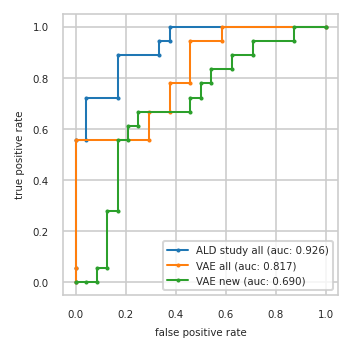

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.556   0.083 0.000
3          0.042 0.556   0.292 0.556   0.083 0.056
4          0.042 0.722   0.292 0.667   0.125 0.056
5          0.167 0.722   0.375 0.667   0.125 0.278
6          0.167 0.889   0.375 0.778   0.167 0.278
7          0.333 0.889   0.458 0.778   0.167 0.556
8          0.333 0.944   0.458 0.944   0.208 0.556
9          0.375 0.944   0.583 0.944   0.208 0.611
10         0.375 1.000   0.583 1.000   0.250 0.611
11         1.000 1.000   1.000 1.000   0.250 0.667
12           NaN   NaN     NaN   NaN   0.458 0.667
13           NaN   NaN     NaN   NaN   0.458 0.722
14           NaN   NaN     NaN   NaN   0.500 0.722
15           NaN   NaN     NaN   NaN   0.500 0.778
16           NaN   NaN     NaN   NaN   0.542 0.778
17           NaN   NaN     NaN   NaN   0.542 0.833
18           NaN   NaN     NaN   NaN   0.625 0.833
19           NaN   NaN     NaN   NaN   0.625 0.889
20           NaN   NaN     NaN   NaN   0.708 0.889
21           NaN   NaN     NaN   NaN   0.708 0.944
22           NaN   NaN     NaN   NaN   0.875 0.944
23           NaN   NaN     NaN   NaN   0.875 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,B0QYF8;P02144,I3L3E6;Q658N2,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,E7EUF1;Q13822-3,P08253,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,P14174,P04075,J3KSJ8;Q9UD71;Q9UD71-2
4,P61981,P14174,P31321
5,P04075,Q9Y2T3;Q9Y2T3-3,None
6,P01597;P04432,P15151-2,None
7,P05413;S4R371,P61981,None
8,Q9Y2T3;Q9Y2T3-3,Q14894,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


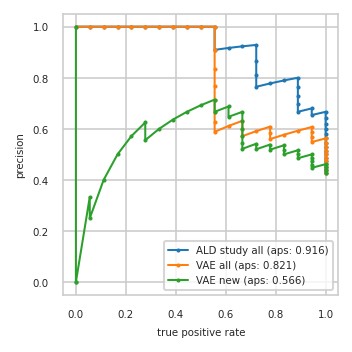

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.680 0.944     0.560 0.778     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.591 0.722     0.545 0.667
21         0.762 0.889     0.571 0.667     0.571 0.667
22         0.800 0.889     0.600 0.667     0.600 0.667
23         0.789 0.833     0.632 0.667     0.632 0.667
24         0.778 0.778     0.611 0.611     0.667 0.667
25         0.765 0.722     0.588 0.556     0.647 0.611
26         0.812 0.722     0.625 0.556     0.688 0.611
27         0.867 0.722     0.667 0.556     0.667 0.556
28         0.929 0.722     0.714 0.556     0.714 0.556
29         0.923 0.667     0.769 0.556     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


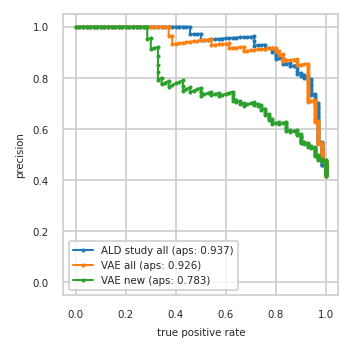

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


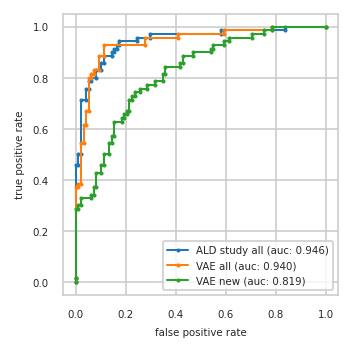

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}